In [45]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import math
import os
import tempfile
import matplotlib as mpl
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np



In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#Karpathy 1. fix random seed
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [4]:
ATT_FILE_NAME = "FootballPlayerPreparedCleanAttributes.csv"
ONE_HOT_ENCODED_CLASSES_FILE_NAME = "FootballPlayerOneHotEncodedClasses.csv"

In [5]:
att = pd.read_csv(ATT_FILE_NAME)
target = pd.read_csv(ONE_HOT_ENCODED_CLASSES_FILE_NAME)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
att.describe()

,Crossing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Reactions,ShotPower,Stamina,LongShots,Aggression,Positioning,Vision,Composure
count,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000
mean,0.053537,0.064942,0.168294,-0.081373,0.122654,-0.030012,-0.132537,0.002751,0.076091,0.098800,0.125965,0.169170,-0.025506,0.136145,0.043417,0.060219,0.036497
std,0.344606,0.293820,0.268085,0.369549,0.301492,0.364944,0.358826,0.334822,0.282066,0.233806,0.326638,0.324097,0.379027,0.352347,0.349409,0.314939,0.274291
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.195122,-0.139241,0.013699,-0.375000,-0.012048,-0.325301,-0.428571,-0.189189,-0.070423,-0.066667,-0.086420,-0.014493,-0.301205,-0.097561,-0.166667,-0.146341,-0.162162
50%,0.097561,0.088608,0.205479,-0.075000,0.180723,-0.012048,-0.190476,0.054054,0.098592,0.093333,0.160494,0.188406,0.036145,0.170732,0.095238,0.097561,0.054054
75%,0.317073,0.265823,0.342466,0.200000,0.325301,0.253012,0.142857,0.243243,0.267606,0.253333,0.358025,0.391304,0.277108,0.390244,0.285714,0.292683,0.243243
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
target.head()

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0


In [9]:
clases = np.argmax(target.to_numpy(),axis=1)

In [10]:
np.bincount(clases) # contar cuantos elemntos tengo de cada clase en el conjunto de datos

array([4296, 3868, 4353, 3605], dtype=int64)

In [11]:
c1, c2,c3,c4= np.bincount(clases)
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}") #lo mismo de arriba

Total: 16122. C1 4296, c2 3868, c3 4353, c4 3605


In [12]:
X_train,X_rem,y_train,y_rem = train_test_split(att,target,train_size=0.8)
X_valid,X_test,y_valid,y_test = train_test_split(X_rem,y_rem,train_size=0.5)
#80 % train   --- 10% val 10% test

In [13]:
c1, c2,c3,c4= np.bincount(np.argmax(y_train.to_numpy(),axis=1))
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}")

Total: 12897. C1 3455, c2 3086, c3 3479, c4 2877


In [61]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
]

METRICS2 = [

      keras.metrics.CategoricalAccuracy(name='accuracy')


]


In [15]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [74]:
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [24]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels,predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


Observamos el overfit del modelo

In [ ]:
plt.plot(h_100x4x100.history['val_categorical_accuracy'])
plt.plot(h_100x4x100.history['categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy','train_accuracy'], loc='upper left')
plt.show()
# "Loss"

In [ ]:
plt.plot(h_128128.history['val_categorical_accuracy'])
plt.plot(h_nocapas.history['val_categorical_accuracy'])
plt.plot(h_512512.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['h28128', 'nocapas','512512'], loc='upper left')
plt.show()
# "Loss"


In [18]:
def build_model(n_hidden=1, n_neurons_ocultas=[30], input_shape=(8,), 
                activation_o="relu", optimizer="adam", loss="categorical_crossentropy", metrics=METRICS, 
                activation_s="soft_max", n_neurons_salida=4):     
    model = keras.models.Sequential()     
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    if n_hidden != len(n_neurons_ocultas):
        print("error, tamaño de la lista de n_neuronas no corresponde al umero de capas")
        return -1
    for layer in range(n_hidden):         
        model.add(keras.layers.Dense(n_neurons_ocultas[layer], activation="relu"))     
  
    model.add(keras.layers.Dense(n_neurons_salida, activation=activation_s))  
    model.compile(optimizer=optimizer,   
              loss=loss,
              metrics=metrics)    
    return model

In [68]:
  
first_decay_steps = 1000 
initial_learning_rate = 1e-3
#lr_decayed_fn = (   tf.keras.optimizers.schedules.CosineDecayRestarts(       initial_learning_rate,       first_decay_steps))
optimizer = keras.optimizers.Adam(learning_rate=1e-3) 
modelo = build_model(3, [100,50,25], (17,), "relu", optimizer, "categorical_crossentropy", METRICS, "softmax", 4)

BATCH_SIZE=256
EPOCHS=100

modelo.summary()
results_fit= modelo.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_test,y_test), batch_size=BATCH_SIZE)












Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 100)               1800      
                                                                 
 dense_65 (Dense)            (None, 50)                5050      
                                                                 
 dense_66 (Dense)            (None, 25)                1275      
                                                                 
 dense_67 (Dense)            (None, 4)                 104       
                                                                 
Total params: 8,229
Trainable params: 8,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
51/51 [==============================] - 1s 10ms/step - loss: 1.1929 - tp: 12242.0000 - fp: 2066.0000 - tn: 75316.0000 - fn: 13552.0000 - accuracy: 0.6536 - precision: 0.8

Epoch 21/100
51/51 [==============================] - 0s 3ms/step - loss: 0.4099 - tp: 10561.0000 - fp: 2255.0000 - tn: 36436.0000 - fn: 2336.0000 - accuracy: 0.8217 - precision: 0.8240 - recall: 0.8189 - val_loss: 0.4216 - val_tp: 1301.0000 - val_fp: 293.0000 - val_tn: 4546.0000 - val_fn: 312.0000 - val_accuracy: 0.8146 - val_precision: 0.8162 - val_recall: 0.8066
Epoch 22/100
51/51 [==============================] - 0s 3ms/step - loss: 0.4082 - tp: 10563.0000 - fp: 2244.0000 - tn: 36447.0000 - fn: 2334.0000 - accuracy: 0.8230 - precision: 0.8248 - recall: 0.8190 - val_loss: 0.4157 - val_tp: 1306.0000 - val_fp: 293.0000 - val_tn: 4546.0000 - val_fn: 307.0000 - val_accuracy: 0.8165 - val_precision: 0.8168 - val_recall: 0.8097
Epoch 23/100
51/51 [==============================] - 0s 3ms/step - loss: 0.4054 - tp: 10596.0000 - fp: 2216.0000 - tn: 36475.0000 - fn: 2301.0000 - accuracy: 0.8244 - precision: 0.8270 - recall: 0.8216 - val_loss: 0.4171 - val_tp: 1304.0000 - val_fp: 293.0000 - v

51/51 [==============================] - 0s 3ms/step - loss: 0.3841 - tp: 10675.0000 - fp: 2146.0000 - tn: 36545.0000 - fn: 2222.0000 - accuracy: 0.8307 - precision: 0.8326 - recall: 0.8277 - val_loss: 0.4192 - val_tp: 1318.0000 - val_fp: 287.0000 - val_tn: 4552.0000 - val_fn: 295.0000 - val_accuracy: 0.8202 - val_precision: 0.8212 - val_recall: 0.8171
Epoch 44/100
51/51 [==============================] - 0s 3ms/step - loss: 0.3819 - tp: 10691.0000 - fp: 2132.0000 - tn: 36559.0000 - fn: 2206.0000 - accuracy: 0.8319 - precision: 0.8337 - recall: 0.8290 - val_loss: 0.4095 - val_tp: 1306.0000 - val_fp: 296.0000 - val_tn: 4543.0000 - val_fn: 307.0000 - val_accuracy: 0.8134 - val_precision: 0.8152 - val_recall: 0.8097
Epoch 45/100
51/51 [==============================] - 0s 3ms/step - loss: 0.3813 - tp: 10734.0000 - fp: 2094.0000 - tn: 36597.0000 - fn: 2163.0000 - accuracy: 0.8353 - precision: 0.8368 - recall: 0.8323 - val_loss: 0.4104 - val_tp: 1309.0000 - val_fp: 293.0000 - val_tn: 4546.0

51/51 [==============================] - 0s 3ms/step - loss: 0.3684 - tp: 10804.0000 - fp: 2019.0000 - tn: 36672.0000 - fn: 2093.0000 - accuracy: 0.8407 - precision: 0.8425 - recall: 0.8377 - val_loss: 0.4061 - val_tp: 1306.0000 - val_fp: 291.0000 - val_tn: 4548.0000 - val_fn: 307.0000 - val_accuracy: 0.8134 - val_precision: 0.8178 - val_recall: 0.8097
Epoch 66/100
51/51 [==============================] - 0s 3ms/step - loss: 0.3644 - tp: 10799.0000 - fp: 2024.0000 - tn: 36667.0000 - fn: 2098.0000 - accuracy: 0.8403 - precision: 0.8422 - recall: 0.8373 - val_loss: 0.4138 - val_tp: 1307.0000 - val_fp: 294.0000 - val_tn: 4545.0000 - val_fn: 306.0000 - val_accuracy: 0.8146 - val_precision: 0.8164 - val_recall: 0.8103
Epoch 67/100
51/51 [==============================] - 0s 3ms/step - loss: 0.3649 - tp: 10833.0000 - fp: 1992.0000 - tn: 36699.0000 - fn: 2064.0000 - accuracy: 0.8426 - precision: 0.8447 - recall: 0.8400 - val_loss: 0.4143 - val_tp: 1316.0000 - val_fp: 287.0000 - val_tn: 4552.0

51/51 [==============================] - 0s 3ms/step - loss: 0.3493 - tp: 10926.0000 - fp: 1907.0000 - tn: 36784.0000 - fn: 1971.0000 - accuracy: 0.8489 - precision: 0.8514 - recall: 0.8472 - val_loss: 0.4100 - val_tp: 1320.0000 - val_fp: 286.0000 - val_tn: 4553.0000 - val_fn: 293.0000 - val_accuracy: 0.8208 - val_precision: 0.8219 - val_recall: 0.8184
Epoch 88/100
51/51 [==============================] - 0s 3ms/step - loss: 0.3493 - tp: 10913.0000 - fp: 1921.0000 - tn: 36770.0000 - fn: 1984.0000 - accuracy: 0.8488 - precision: 0.8503 - recall: 0.8462 - val_loss: 0.4152 - val_tp: 1309.0000 - val_fp: 290.0000 - val_tn: 4549.0000 - val_fn: 304.0000 - val_accuracy: 0.8146 - val_precision: 0.8186 - val_recall: 0.8115
Epoch 89/100
51/51 [==============================] - 0s 3ms/step - loss: 0.3488 - tp: 10937.0000 - fp: 1901.0000 - tn: 36790.0000 - fn: 1960.0000 - accuracy: 0.8503 - precision: 0.8519 - recall: 0.8480 - val_loss: 0.4206 - val_tp: 1316.0000 - val_fp: 292.0000 - val_tn: 4547.0

In [69]:
results_evaluate = modelo.evaluate(X_train,y_train,batch_size=BATCH_SIZE)

51/51 [==============================] - 0s 2ms/step - loss: 0.3363 - tp: 10987.0000 - fp: 1795.0000 - tn: 36896.0000 - fn: 1910.0000 - accuracy: 0.8563 - precision: 0.8596 - recall: 0.8519


In [71]:
train_predictions_baseline = modelo.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = modelo.predict(X_test, batch_size=BATCH_SIZE)
print(train_predictions_baseline)
print(test_predictions_baseline)

7/7 [==============================] - 0s 1ms/step
[[8.4507108e-02 9.1348833e-01 2.0037722e-03 7.6855514e-07]
 [9.9999511e-01 4.8492393e-06 6.7751062e-14 4.1773890e-15]
 [1.9158697e-10 1.0050093e-08 7.0949423e-04 9.9929047e-01]
 ...
 [1.8978361e-11 1.7414610e-09 1.5118647e-04 9.9984884e-01]
 [3.1519547e-04 3.3789363e-02 8.9942408e-01 6.6471308e-02]
 [3.0538136e-02 9.6791047e-01 1.5510155e-03 3.1362043e-07]]
[[3.63882817e-02 5.17773032e-01 4.44313288e-01 1.52539241e-03]
 [4.06471463e-06 5.19992504e-03 9.84117091e-01 1.06788585e-02]
 [2.77966150e-10 1.54069060e-08 2.25912925e-04 9.99774039e-01]
 ...
 [2.26110551e-05 6.56283870e-02 9.33719397e-01 6.29549904e-04]
 [1.09093831e-10 2.72932343e-09 1.14888338e-04 9.99885082e-01]
 [2.76906509e-02 9.18452203e-01 5.38421012e-02 1.50399619e-05]]


loss :  0.33628278970718384
tp :  10987.0
fp :  1795.0
tn :  36896.0
fn :  1910.0
accuracy :  0.8563231825828552
precision :  0.8595681190490723
recall :  0.8519035577774048



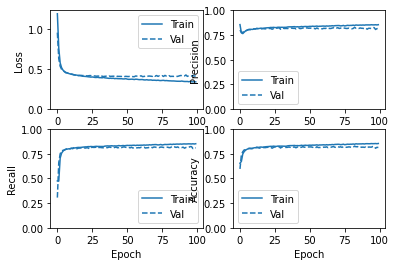

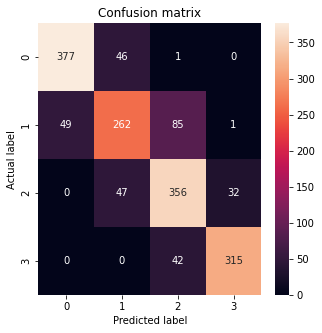

In [75]:
plot_metrics(results_fit)

for name, value in zip(modelo.metrics_names, results_evaluate):
  print(name, ': ', value)
print()

plot_cm(np.argmax(y_test.to_numpy(),axis=1), test_predictions_baseline.argmax(axis=1))

In [76]:
y_pred = test_predictions_baseline.argmax(axis=1)
np.argmax(np.asarray(y_test),axis=1)
print(classification_report(y_pred, np.argmax(np.asarray(y_test),axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.8892    0.8850    0.8871       426
           1     0.6599    0.7380    0.6968       355
           2     0.8184    0.7355    0.7748       484
           3     0.8824    0.9052    0.8936       348

    accuracy                         0.8122      1613
   macro avg     0.8125    0.8159    0.8131      1613
weighted avg     0.8160    0.8122    0.8129      1613



In [64]:
print(classification_report(test_predictions_baseline,y_test))
#plt.plot(results_fit.history['val_categorical_accuracy'])
#plt.plot(results_fit.history['categorical_accuracy'])

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets